# **Ndam Optimizer from Scratch in Python**
*By Cristian Leo*

[View the full Article here](https://medium.com/towards-data-science/the-math-behind-nadam-optimizer-47dc1970d2cc)

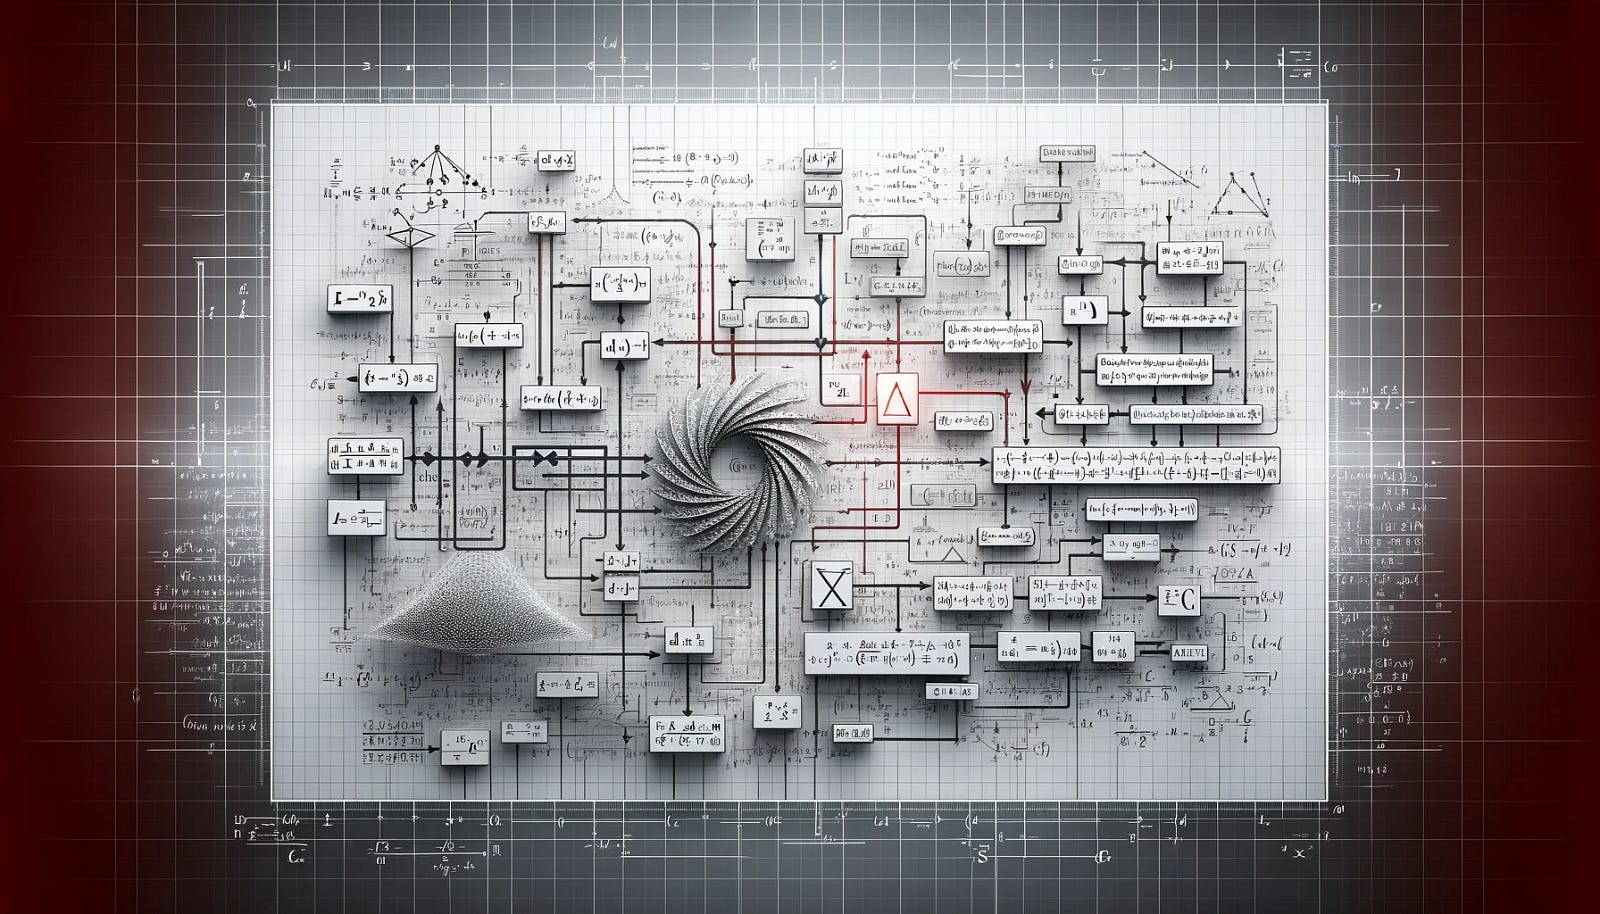

## **Import Required Libraries**

In [3]:
# Basic Libraries
import numpy as np
import pandas as pd

# Load Data
from sklearn.datasets import load_diabetes

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Fine Tuning
import optuna

# Filter Warnings
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Nadam Optimizer Class**

In [4]:
class NadamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def initialize_moments(self, params):
        self.m = {k: np.zeros_like(v) for k, v in params.items()}
        self.v = {k: np.zeros_like(v) for k, v in params.items()}

    def update_params(self, params, grads):
        if self.m is None or self.v is None:
            self.initialize_moments(params)

        self.t += 1
        updated_params = {}
        mu_t = self.beta1 * (1 - 0.5 * 0.96 ** (self.t * 0.004))
        mu_t1 = self.beta1 * (1 - 0.5 * 0.96 ** ((self.t + 1) * 0.004))
        for key in params.keys():
            g_tilde = grads[key] / (1 - np.prod([self.beta1] * self.t))
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * np.square(grads[key])

            m_corrected = self.m[key] / (1 - mu_t1 ** self.t)
            v_corrected = self.v[key] / (1 - self.beta2 ** self.t)

            m_bar = (1 - mu_t) * g_tilde + mu_t1 * m_corrected

            updated_params[key] = params[key] - self.learning_rate * m_bar / (np.sqrt(v_corrected) + self.epsilon)

        return updated_params

## **Linear Regression Class**

In [5]:
# Linear Regression Model
class LinearRegression:
    def __init__(self, n_features):
        """
        Constructor for the LinearRegression class.

        Parameters
        ----------
        n_features : int
            Number of features in the input data.
        
        Returns
        -------
        None.
        """
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()

    def predict(self, X):
        """
        Predicts the target variable given the input data.

        Parameters
        ----------
        X : numpy array
            Input data.

        Returns
        -------
        numpy array
            Predictions.
        """
        return np.dot(X, self.weights) + self.bias

## **Model Trainer Class**

In [6]:
class ModelTrainer:
    def __init__(self, model, optimizer, n_epochs):
        """
        Constructor for the ModelTrainer class.

        Parameters
        ----------
        model : object
            Model to be trained.
        optimizer : object
            Optimizer to be used for training.
        n_epochs : int
            Number of training epochs.

        Returns
        -------
        None.
        """
        self.model = model
        self.optimizer = optimizer
        self.n_epochs = n_epochs

    def compute_gradients(self, X, y):
        """
        Computes the gradients of the mean squared error loss function
        with respect to the model parameters.

        Parameters
        ----------
        X : numpy array
            Input data.
        y : numpy array
            Target variable.
        
        Returns
        -------
        dict
            Dictionary containing the gradients for each parameter.
        """
        predictions = self.model.predict(X)
        errors = predictions - y
        dW = 2 * np.dot(X.T, errors) / len(y)
        db = 2 * np.mean(errors)
        return {'weights': dW, 'bias': db}

    def train(self, X, y, verbose=False):
        """
        Runs the training loop, updating the model parameters and optionally printing the loss.

        Parameters
        ----------
        X : numpy array
            Input data.
        y : numpy array
            Target variable.
        
        Returns
        -------
        None.
        """
        for epoch in range(self.n_epochs):
            grads = self.compute_gradients(X, y)
            params = {'weights': self.model.weights, 'bias': self.model.bias}
            updated_params = self.optimizer.update_params(params, grads)

            self.model.weights = updated_params['weights']
            self.model.bias = updated_params['bias']

            # Optionally, print loss here to observe training
            loss = np.mean((self.model.predict(X) - y) ** 2)
            if epoch % 1000 == 0 and verbose:
                print(f"Epoch {epoch}, Loss: {loss}")

## **Load Diabetes Data**

In [7]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

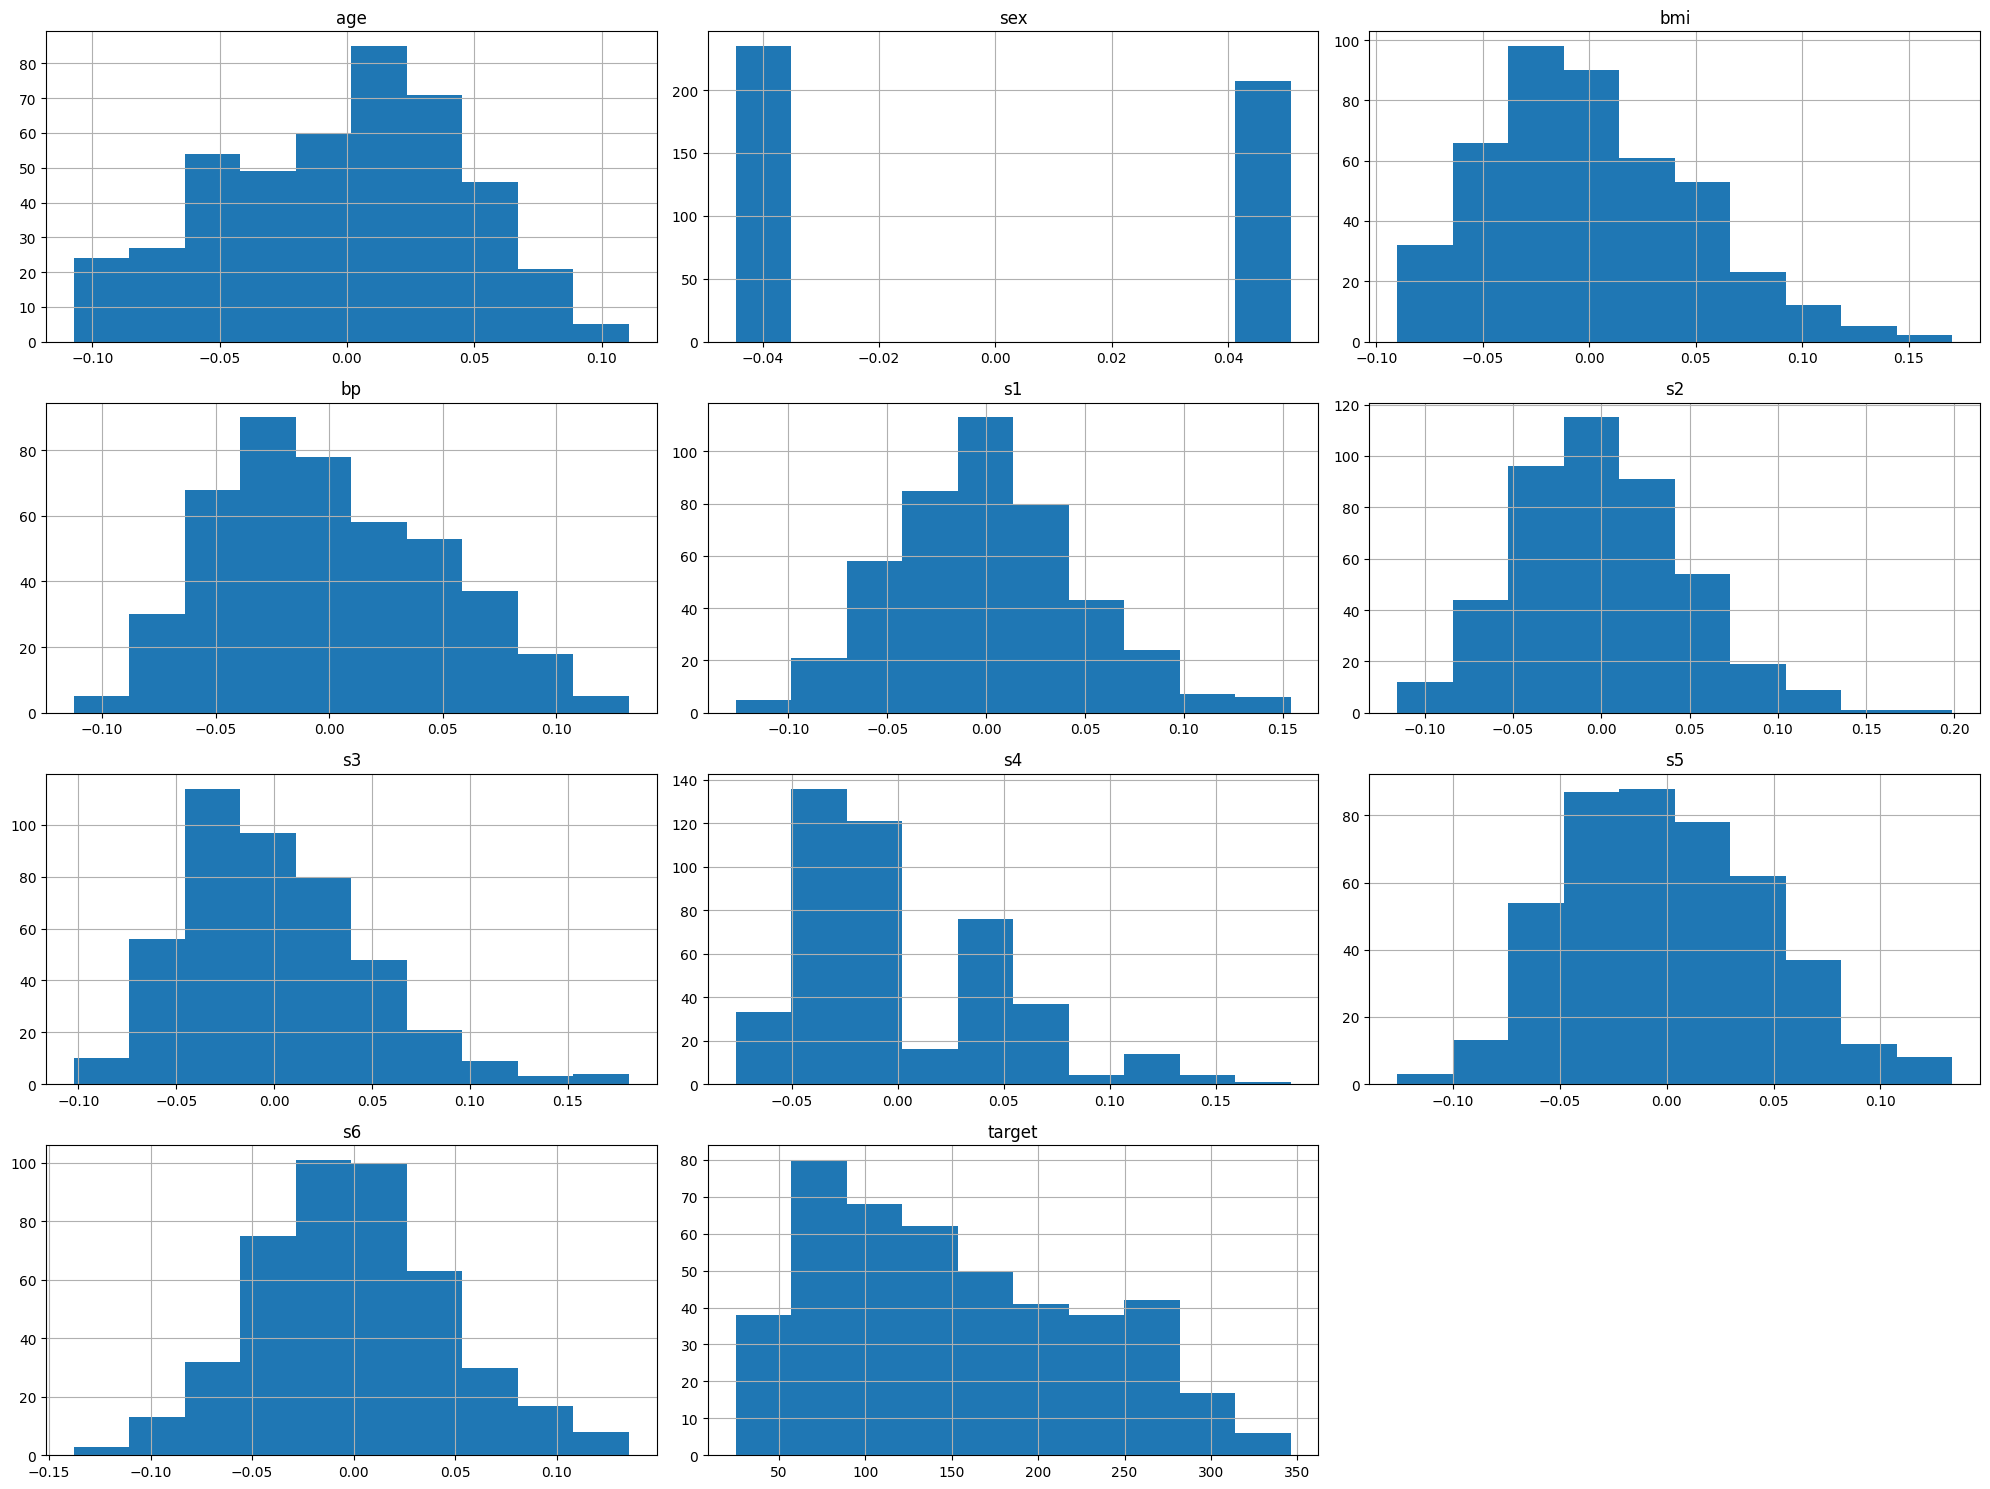

In [8]:
# Create histograms for each feature
df.hist(bins=10, figsize=(20, 15))
plt.tight_layout()
plt.show()

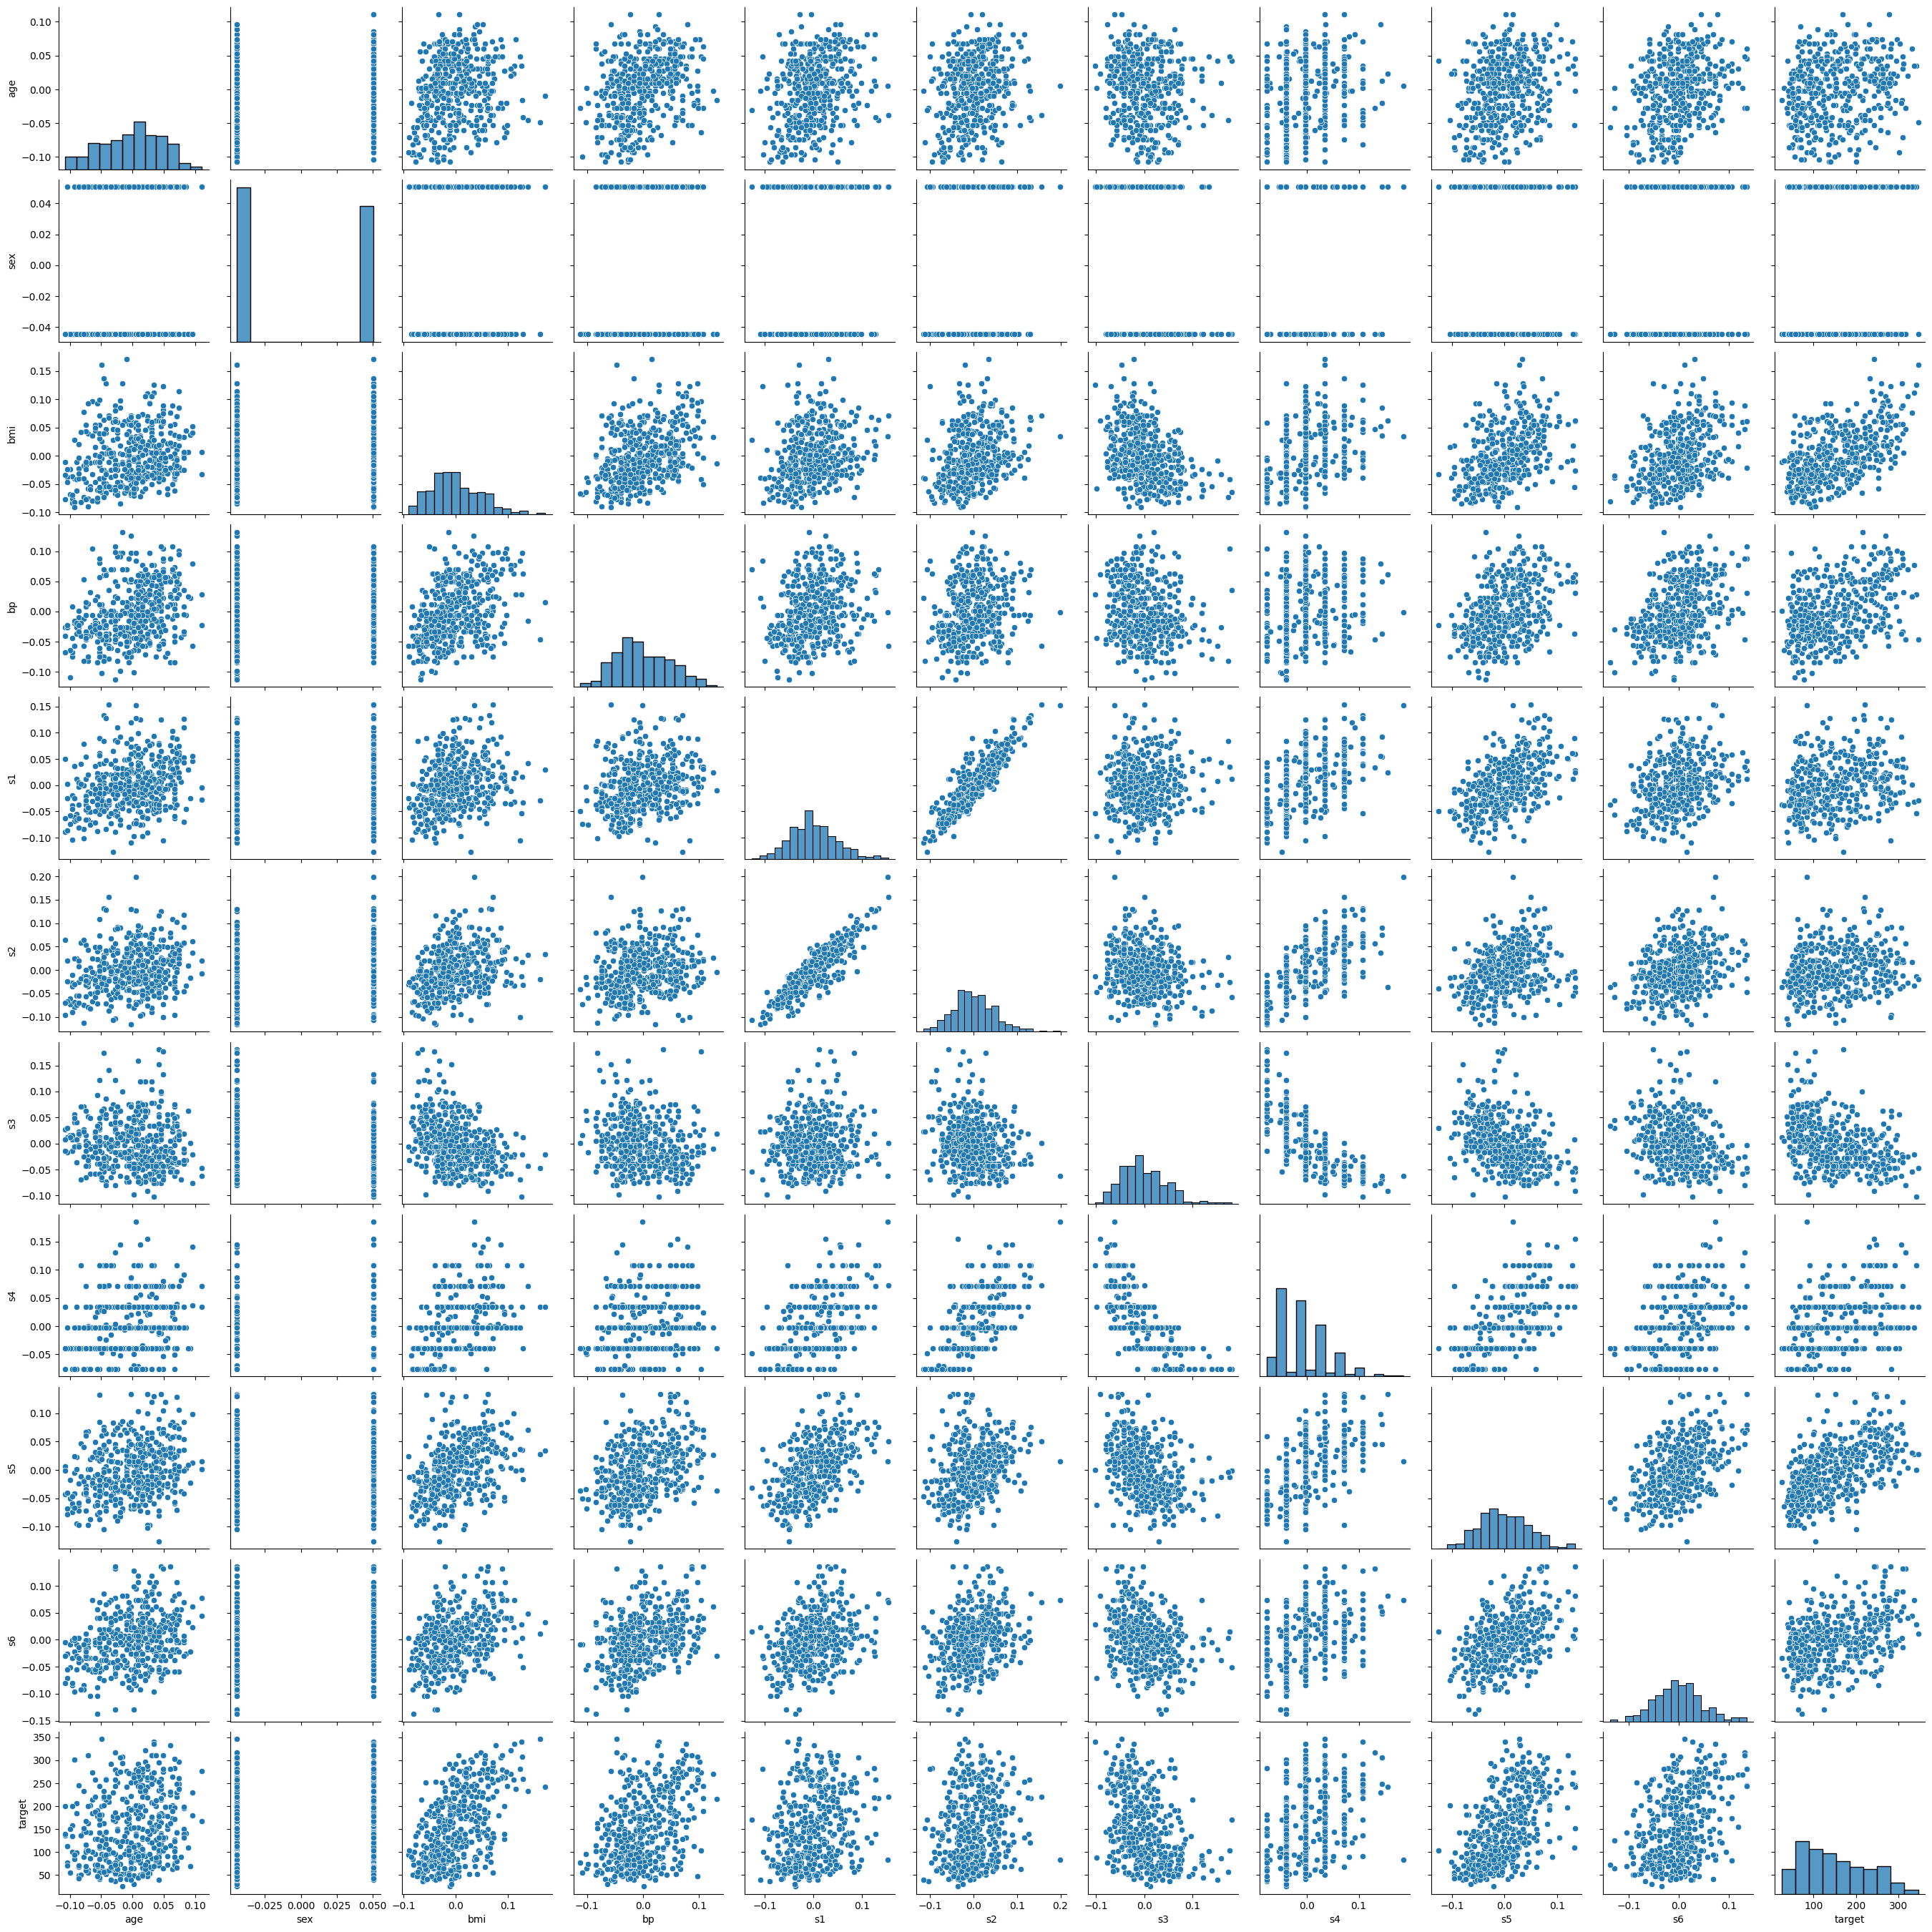

In [9]:
# Pairplot of the features
sns.pairplot(df)

## **Split Data**

In [10]:
# Get the input features (X) and target values (y)
X = diabetes.data
y = diabetes.target

# Split the dataset into training and test sets
def split_dataset(X, y, test_ratio=0.2):
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = split_dataset(X, y)
X_train, X_val, y_train, y_val = split_dataset(X_train, y_train)

## **Fine Tune Model with Optuna**

In [11]:
def objective(trial):
    n_features = X_train.shape[1]

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    beta1 = trial.suggest_uniform('beta1', 0.9, 0.999)
    beta2 = trial.suggest_uniform('beta2', 0.99, 0.9999)
    epsilon = trial.suggest_loguniform('epsilon', 1e-10, 1e-5)

    n_epochs = trial.suggest_int('epochs', 1000, 100000)

    # Define the model
    model = LinearRegression(n_features)
    optimizer = NadamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    trainer = ModelTrainer(model, optimizer, n_epochs=n_epochs)

    # Train the model
    trainer.train(X_train, y_train, verbose=False)

    # Compute the validation loss
    val_loss = np.mean((model.predict(X_val) - y_val) ** 2)

    return val_loss

# Create the study object
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the study, use more trials to obtain better results, use less trials to be more cost-efficient
study.optimize(objective, n_trials=10)

In [12]:
# Print optimization results
print("---------------------------------------")
print('Number of finished trials:', len(study.trials))
print('Best trial:')
for key, value in study.best_trial.params.items():
    if key == 'epochs' or key == 'epsilon':
        print(f'    {key}: {value}')
    else:
        print(f'    {key}: {value:.3f}')

---------------------------------------
Number of finished trials: 10
Best trial:
    learning_rate: 0.017
    beta1: 0.930
    beta2: 0.991
    epsilon: 2.637333993381524e-07
    epochs: 44575


In [13]:
# Get the best model
n_features = X_train.shape[1]
best_model = LinearRegression(n_features)
optimizer = NadamOptimizer(learning_rate=study.best_params['learning_rate'],
                          beta1=study.best_params['beta1'],
                          beta2=study.best_params['beta2'],
                          epsilon=study.best_params['epsilon'])

# Train the model
trainer = ModelTrainer(best_model, optimizer, n_epochs=study.best_params['epochs'])
trainer.train(X_train, y_train)

# Compute the test loss
test_loss = np.mean((best_model.predict(X_test) - y_test) ** 2)**0.5
print(f'Test loss: {test_loss:.2f}')

Test loss: 51.18


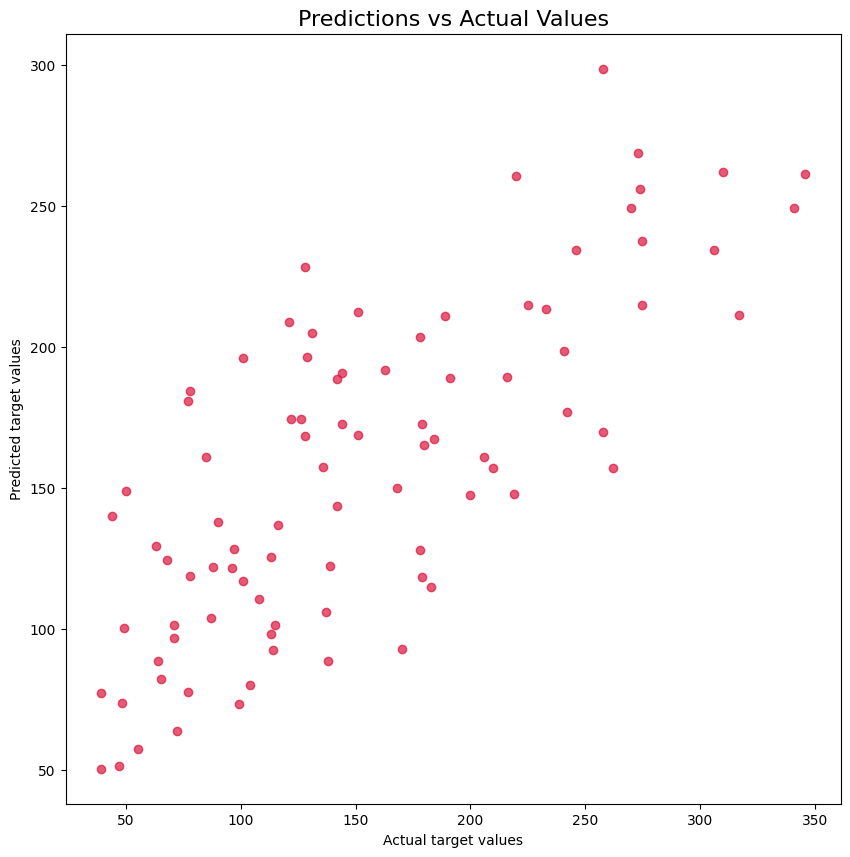

In [14]:
# Plot the predictions vs the actual values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, best_model.predict(X_test), c='crimson', alpha=0.7)
plt.title('Predictions vs Actual Values', fontsize=16)
plt.xlabel('Actual target values')
plt.ylabel('Predicted target values')
plt.show()